LOAD RELEVANT LIBRARIES

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import single, average, complete, fcluster, linkage
import re
from sklearn.metrics import adjusted_rand_score, jaccard_score
from sklearn.cluster import AgglomerativeClustering
from itertools import combinations
from collections import defaultdict

INPUT SPECIES NAME (FOR LABELING)

In [2]:
species = 'E_faecalis'

READ IN DATA

In [3]:
# make it possible for user to select which tools they are inputting??

skani_file_path = f'/Users/Annaliese/Desktop/PopGenStats_Project/data/{species}/distances/skani.tsv.gz'

In [4]:
skani_matrix = pd.read_csv(skani_file_path, sep='\t')
skani_matrix['Tool'] = 'skANI'

TIDY TOOL MATRIX
- SHORTEN SAMPLE FILE NAMES
- ASSIGN SAMPLES A SIMPLIFIED SAMPLE ID
- CALCULATE ANI FOR ALIGNED BASES

In [5]:
def edit_accession_id(str):
    match = re.search(r'(GCF_|GCA_)\d{9}\.\d|flye.SQK-NBD\d{3}-\d{2}_barcode\d{2}', str)
    if match:
        return match.group(0)
    return None

In [6]:
skani_matrix['aligned_bases1'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_ref'] / 100)
skani_matrix['aligned_bases2'] = skani_matrix['ANI'] * (skani_matrix['Align_fraction_query'] / 100)

skani_matrix['Ref_file'] = skani_matrix['Ref_file'].apply(edit_accession_id)
skani_matrix['Query_file'] = skani_matrix['Query_file'].apply(edit_accession_id)

skani_sample_names = sorted(set(skani_matrix['Ref_file']) | set(skani_matrix['Query_file']))
skani_mapper = {name: f'sample{idx}' for idx, name in enumerate(skani_sample_names)}

skani_matrix['ref'] = skani_matrix['Ref_file'].map(skani_mapper)
skani_matrix['query'] = skani_matrix['Query_file'].map(skani_mapper)

skani_matrix

,Ref_file,Query_file,ANI,Align_fraction_ref,Align_fraction_query,Ref_name,Query_name,Tool,aligned_bases1,aligned_bases2,ref,query
0,GCA_000205205.1,GCF_000178175.1,99.71,87.06,95.67,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_ADKN01000079.1 Enterococcus faecalis PC1.1 ...,skANI,86.807526,95.392557,sample0,sample189
1,GCA_000205205.1,GCF_000396185.1,98.80,85.83,79.01,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_KB948558.1 Enterococcus faecalis EnGen0204 ...,skANI,84.800040,78.061880,sample0,sample378
2,GCA_000205205.1,GCF_001544235.1,98.44,82.74,88.38,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_BCQC01000001.1 Enterococcus faecalis ATCC 1...,skANI,81.449256,87.001272,sample0,sample567
3,GCA_000205205.1,GCF_003047245.1,98.44,85.03,85.81,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_CM009687.1 Enterococcus faecalis strain AHG...,skANI,83.703532,84.471364,sample0,sample756
4,GCA_000205205.1,GCF_005236415.1,98.46,81.80,86.00,GL883975.1 Enterococcus faecalis TX1467 genomi...,NZ_QPVM01000010.1 Enterococcus faecalis strain...,skANI,80.540280,84.675600,sample0,sample945
...,...,...,...,...,...,...,...,...,...,...,...,...
4516510,GCF_902165735.1,GCF_902166365.1,98.86,88.10,84.40,NZ_CABHHO010000001.1 Enterococcus faecalis str...,NZ_CABHKD010000001.1 Enterococcus faecalis str...,skANI,87.095660,83.437840,sample2962,sample2977
4516511,GCF_902165735.1,GCF_902165985.1,98.92,88.90,87.14,NZ_CABHHO010000001.1 Enterococcus faecalis str...,NZ_CABHIT010000001.1 Enterococcus faecalis str...,skANI,87.939880,86.198888,sample2962,sample2974
4516512,GCF_902165735.1,GCF_902165915.1,98.86,87.02,87.92,NZ_CABHHO010000001.1 Enterococcus faecalis str...,NZ_CABHIC010000001.1 Enterococcus faecalis str...,skANI,86.027972,86.917712,sample2962,sample2971
4516513,GCF_902165735.1,GCF_902165805.1,98.86,87.43,90.25,NZ_CABHHO010000001.1 Enterococcus faecalis str...,NZ_CABHIB010000001.1 Enterococcus faecalis str...,skANI,86.433298,89.221150,sample2962,sample2968


CHECK THAT SAMPLES MEET SPECIES-LEVEL CUTOFF

In [7]:
if (skani_matrix['ANI'].min() < 95).any().any():
    raise ValueError("Samples do not meet species-level ANI cutoff (95%)")

CHECK HOW MANY SAMPLES BELONG TO OUR LAB

In [8]:
unique_barcodes = skani_matrix['Ref_file'].str.contains(r'flye.SQK-NBD114-96_barcode\d{2}', regex=True)
unique_names = skani_matrix[unique_barcodes]['Ref_file'].unique()
len(unique_names)

0

MAKE ANI MATRIX
- PLOT SAMPLES AGAINST EACH OTHER
- MANUALLY ADD DIAGONAL DATA (SAMPLES PLOTTED AGAINST THEMSELVES - 100% SIMILARITY)

In [9]:
skani_diagonal_data = []
for sample in skani_sample_names:
    skani_diagonal_data.append({
        'Ref_file': sample,
        'Query_file': sample,
        'ANI': 100,
        'Align_fraction_ref': 100,
        'Align_fraction_query': 100,
        'Ref_name': '',
        'Query_name': '',
        'ref': skani_mapper[sample],
        'query': skani_mapper[sample],
        'aligned_bases1': 100,
        'aligned_bases2': 100,
        'Tool': 'skANI'
    })

skani_diagonal_df = pd.DataFrame(skani_diagonal_data)
skani_matrix = pd.concat([skani_matrix, skani_diagonal_df], ignore_index=True)

skani_matrix = skani_matrix.sort_values(by=['Ref_file', 'Query_file']).reset_index(drop=True)

skani_upper_triangle = skani_matrix.pivot(index='ref', columns='query', values='ANI').fillna(0)
skani_upper_triangle = skani_upper_triangle[sorted(skani_upper_triangle.columns)]

skani_lower_triangle = skani_matrix.pivot(index='query', columns='ref', values='ANI').fillna(0)
skani_lower_triangle = skani_lower_triangle[sorted(skani_lower_triangle.columns)]

new_skani_matrix = skani_upper_triangle + skani_lower_triangle
new_skani_matrix[:] = np.where(new_skani_matrix==200, 100, new_skani_matrix)

new_skani_matrix

query,sample0,sample1,sample10,sample100,sample1000,sample1001,sample1002,sample1003,sample1004,sample1005,...,sample990,sample991,sample992,sample993,sample994,sample995,sample996,sample997,sample998,sample999
ref,,,,,,,,,,,,,,,,,,,,,
sample0,100.00,98.49,98.72,98.48,98.57,98.57,98.57,98.49,98.50,98.51,...,98.43,98.51,98.57,98.57,98.57,98.57,98.57,98.57,98.47,98.57
sample1,98.49,100.00,98.56,98.49,98.57,98.54,98.54,98.52,98.50,98.54,...,98.40,98.56,98.57,98.54,98.57,98.56,98.57,98.56,98.55,98.54
sample10,98.72,98.56,100.00,98.76,98.73,98.73,98.73,98.67,98.65,98.66,...,98.59,98.67,98.73,98.73,98.73,98.73,98.73,98.74,98.63,98.74
sample100,98.48,98.49,98.76,100.00,98.51,98.51,98.51,98.50,98.48,98.49,...,98.49,98.50,98.51,98.51,98.51,98.51,98.51,98.51,98.67,98.51
sample1000,98.57,98.57,98.73,98.51,100.00,100.00,100.00,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,100.00,99.99,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample995,98.57,98.56,98.73,98.51,100.00,99.99,99.99,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,99.99,99.99,99.99
sample996,98.57,98.57,98.73,98.51,100.00,99.99,100.00,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,100.00,99.99,100.00
sample997,98.57,98.56,98.74,98.51,100.00,100.00,100.00,100.00,99.95,99.97,...,99.99,99.97,99.97,100.00,100.00,99.99,100.00,100.00,99.99,100.00


VISUALIZE ANI DISTRIBUTION

<Axes: xlabel='query', ylabel='ref'>

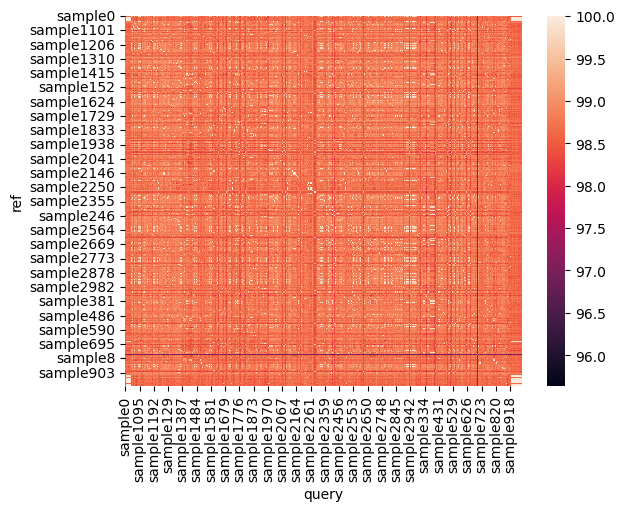

In [10]:
sns.heatmap(new_skani_matrix)

FILTER OUT HIGHLY DIVERGENT SAMPLES

In [11]:
less_than_97_dict = {}

for sample in new_skani_matrix.index:
    less_than_97 = new_skani_matrix.columns[new_skani_matrix.loc[sample] < 97].tolist()
    less_than_97_dict[sample] = less_than_97

for sample, low_similarity_samples in less_than_97_dict.items():
    print(f"{sample}: {low_similarity_samples}")

sample0: ['sample1047', 'sample1058', 'sample1062', 'sample1082', 'sample1518', 'sample2306']
sample1: ['sample1082', 'sample1518', 'sample1523', 'sample2306', 'sample3004', 'sample702', 'sample731']
sample10: ['sample1047', 'sample1058', 'sample1062', 'sample1072', 'sample1082', 'sample1518', 'sample1523', 'sample2118', 'sample2306', 'sample3004', 'sample770', 'sample910', 'sample93']
sample100: ['sample1047', 'sample1058', 'sample1082', 'sample1518', 'sample1523', 'sample2118', 'sample2306', 'sample3004', 'sample699', 'sample702', 'sample731', 'sample770']
sample1000: ['sample1518', 'sample2306']
sample1001: ['sample1518', 'sample2306']
sample1002: ['sample1518', 'sample2306']
sample1003: ['sample1082', 'sample1518', 'sample2306', 'sample731']
sample1004: ['sample1082', 'sample1518', 'sample2306', 'sample699', 'sample731']
sample1005: ['sample1082', 'sample1518', 'sample2306', 'sample699', 'sample731']
sample1006: ['sample1082', 'sample1518', 'sample2306', 'sample699']
sample1007: ['

In [12]:
dissimilarity_matrix = 100 - new_skani_matrix

if (dissimilarity_matrix < 0).any().any():
    raise ValueError("skANI distance matrix contains negative values")

/var/folders/c4/74mrz72x32z07ktyfxzn15cw0000gn/T/ipykernel_91243/389687414.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dissimilarity_matrix, method='average')


2390
ref
sample1058    100.0
dtype: float64


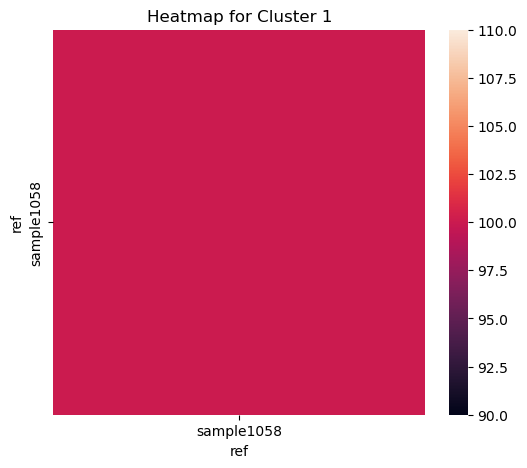

2390
ref
sample1062    100.0
dtype: float64


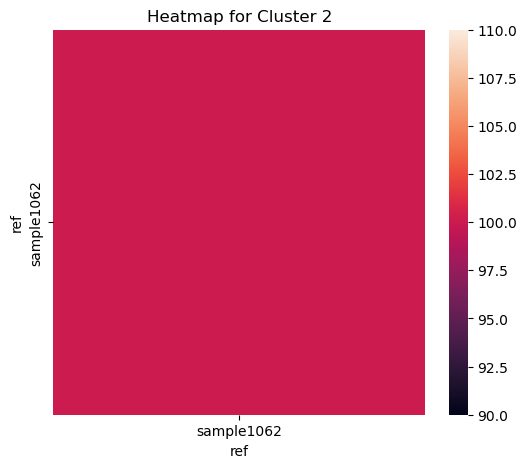

2390
ref
sample1047    100.0
dtype: float64


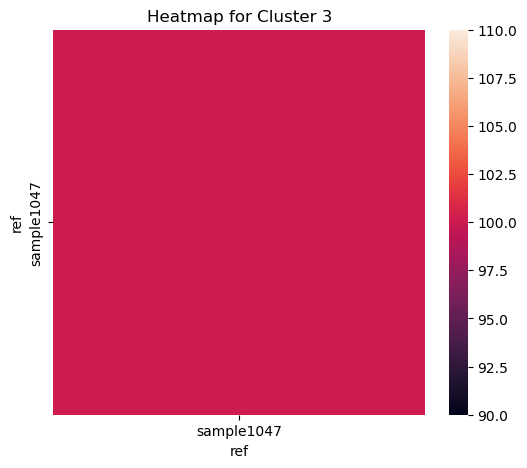

In [14]:
Z = linkage(dissimilarity_matrix, method='average')

def cluster_heatmaps(df, Z, num_clusters):
    clusters = fcluster(Z, t=num_clusters, criterion='distance')
    
    df['cluster'] = clusters
    
    for cluster_num in range(1, num_clusters + 1):
        cluster_samples = df.index[df['cluster'] == cluster_num]
        
        submatrix = df.loc[cluster_samples, cluster_samples]
        
        print(len(df['cluster'].unique()))
        print(submatrix.min())

        plt.figure(figsize=(6, 5))
        sns.heatmap(submatrix, cbar=True)
        plt.title(f"Heatmap for Cluster {cluster_num}")
        plt.show()

num_clusters = 3

cluster_heatmaps(new_skani_matrix, Z, num_clusters)

In [15]:
def cluster_heatmaps(df, max_dist):
    clustering = AgglomerativeClustering(
        metric='precomputed', # will not recalculate distances
        linkage='average', # interested to see other linkages
        distance_threshold=max_dist,
        n_clusters=None
    )
    
    clusters = clustering.fit_predict(df) # assigns samples to clusters
    
    df['cluster'] = clusters
    print(df['cluster'])
    
    unique_clusters = df['cluster'].unique()
    print(f"# clusters: {len(unique_clusters)}")

    cluster_divergence_list = []
    
    for cluster_num in unique_clusters:
        cluster_samples = df.index[df['cluster'] == cluster_num]
        submatrix = df.loc[cluster_samples, cluster_samples]
        
        max_divergence = submatrix.max().max()
        print(f"cluster {cluster_num} max divergence: {max_divergence}")
        
        cluster_divergence_list.append({'cluster': cluster_num, 'max_divergence': max_divergence})
    
    divergence_df = pd.DataFrame(cluster_divergence_list)
    
    return df, divergence_df
        
        # plt.figure(figsize=(6, 5))
        # sns.heatmap(submatrix, cbar=True)
        # plt.title(f"Heatmap for Cluster {cluster_num + 1}")
        # plt.show()

max_clust = 1

dissimilarity_matrix_clusters, max_divergence_df = cluster_heatmaps(dissimilarity_matrix, max_clust)

ref
sample0        9
sample1        0
sample10      10
sample100      8
sample1000    51
              ..
sample995     51
sample996     51
sample997     51
sample998     51
sample999     51
Name: cluster, Length: 3006, dtype: int64
# clusters: 92
cluster 9 max divergence: 1.6899999999999977
cluster 0 max divergence: 1.5799999999999983
cluster 10 max divergence: 1.5699999999999932
cluster 8 max divergence: 1.8900000000000006
cluster 51 max divergence: 0.4300000000000068
cluster 31 max divergence: 0.28000000000000114
cluster 90 max divergence: 1.2000000000000028
cluster 30 max divergence: 1.2999999999999972
cluster 3 max divergence: 1.5300000000000011
cluster 35 max divergence: 0.37000000000000455
cluster 62 max divergence: 0.7399999999999949
cluster 11 max divergence: 1.1099999999999994
cluster 78 max divergence: 1.0100000000000051
cluster 32 max divergence: 0.7199999999999989
cluster 61 max divergence: 0.8700000000000045
cluster 39 max divergence: 0.9899999999999949
cluster 28 max div

IQTREE CLUSTERS

In [16]:
def get_cluster_matrix(df, Z, num_clusters, cluster_num):
    clusters = fcluster(Z, t=num_clusters, criterion='maxclust')
    df['cluster'] = clusters
    
    cluster_samples = df.index[df['cluster'] == cluster_num]
    submatrix = df.loc[cluster_samples, cluster_samples]
    
    return submatrix

get_cluster_matrix(new_skani_matrix, Z, 3, 2)

ref,sample0,sample1,sample10,sample100,sample1000,sample1001,sample1002,sample1003,sample1004,sample1005,...,sample990,sample991,sample992,sample993,sample994,sample995,sample996,sample997,sample998,sample999
ref,,,,,,,,,,,,,,,,,,,,,
sample0,100.00,98.49,98.72,98.48,98.57,98.57,98.57,98.49,98.50,98.51,...,98.43,98.51,98.57,98.57,98.57,98.57,98.57,98.57,98.47,98.57
sample1,98.49,100.00,98.56,98.49,98.57,98.54,98.54,98.52,98.50,98.54,...,98.40,98.56,98.57,98.54,98.57,98.56,98.57,98.56,98.55,98.54
sample10,98.72,98.56,100.00,98.76,98.73,98.73,98.73,98.67,98.65,98.66,...,98.59,98.67,98.73,98.73,98.73,98.73,98.73,98.74,98.63,98.74
sample100,98.48,98.49,98.76,100.00,98.51,98.51,98.51,98.50,98.48,98.49,...,98.49,98.50,98.51,98.51,98.51,98.51,98.51,98.51,98.67,98.51
sample1000,98.57,98.57,98.73,98.51,100.00,100.00,100.00,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,100.00,99.99,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample995,98.57,98.56,98.73,98.51,100.00,99.99,99.99,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,99.99,99.99,99.99
sample996,98.57,98.57,98.73,98.51,100.00,99.99,100.00,99.99,99.96,99.97,...,99.99,99.97,99.97,100.00,100.00,100.00,100.00,100.00,99.99,100.00
sample997,98.57,98.56,98.74,98.51,100.00,100.00,100.00,100.00,99.95,99.97,...,99.99,99.97,99.97,100.00,100.00,99.99,100.00,100.00,99.99,100.00


In [17]:
threshold = np.percentile(new_skani_matrix.values, 97.5)
divergent_samples = new_skani_matrix[(new_skani_matrix > threshold) | (new_skani_matrix < -threshold)].stack().reset_index()

divergent_samples.columns = ['Row_Sample', 'Column_Sample', 'Value']

print(divergent_samples)

       Row_Sample Column_Sample   Value
0         sample0       sample0  100.00
1         sample0    sample1046   99.76
2         sample0    sample1060   99.68
3         sample0    sample1065   99.63
4         sample0     sample108   99.68
...           ...           ...     ...
225905  sample999     sample995   99.99
225906  sample999     sample996  100.00
225907  sample999     sample997  100.00
225908  sample999     sample998   99.99
225909  sample999     sample999  100.00

[225910 rows x 3 columns]


In [18]:
new_skani_matrix_copy = new_skani_matrix.copy()
to_merge = new_skani_matrix_copy['cluster'].reset_index()
to_merge

,ref,cluster
0,sample0,2
1,sample1,2
2,sample10,2
3,sample100,2
4,sample1000,2
...,...,...
3001,sample995,2
3002,sample996,2
3003,sample997,2
3004,sample998,2


In [19]:
to_merge['cluster'].unique()

array([2, 1, 3], dtype=int32)

In [20]:
merged_skani = pd.merge(skani_matrix, to_merge, on='ref', how='left')
iqtree_skani = merged_skani[['Ref_file', 'cluster']].drop_duplicates().reset_index().drop('index', axis=1)

unique_clusters = iqtree_skani['cluster'].unique()
palette = sns.color_palette(None, len(unique_clusters))

cluster_color_map = {cluster: f'rgba({color[0]*255:.2f},{color[1]*255:.2f},{color[2]*255:.2f},1.0)' 
                     for cluster, color in zip(unique_clusters, palette)}

iqtree_skani['colour'] = iqtree_skani['cluster'].map(cluster_color_map)
iqtree_skani

,Ref_file,cluster,colour
0,GCA_000205205.1,2,"rgba(31.00,119.00,180.00,1.0)"
1,GCA_000210115.1,2,"rgba(31.00,119.00,180.00,1.0)"
2,GCA_000499025.1,2,"rgba(31.00,119.00,180.00,1.0)"
3,GCA_000505585.1,2,"rgba(31.00,119.00,180.00,1.0)"
4,GCA_000508705.1,2,"rgba(31.00,119.00,180.00,1.0)"
...,...,...,...
3001,GCF_925301485.1,2,"rgba(31.00,119.00,180.00,1.0)"
3002,GCF_932751005.1,2,"rgba(31.00,119.00,180.00,1.0)"
3003,GCF_932751025.1,2,"rgba(31.00,119.00,180.00,1.0)"
3004,GCF_932751055.1,1,"rgba(44.00,160.00,44.00,1.0)"


In [22]:
with open(f'/Users/Annaliese/Desktop/PopGenStats_Project/data/{species}/tree/iqtree.skani.renamed.treefile.annot.ahc_3.txt', 'w') as f:
    f.write("\n")
    f.write("        DATASET_COLORSTRIP\n\n")
    f.write("        SEPARATOR SPACE\n")
    f.write("        DATASET_LABEL ahc (skani)\n")
    f.write("        COLOR #ff0000\n\n")
    f.write("        COLOR_BRANCHES 0\n\n")
    f.write("        DATA\n\n")
    
    for _, row in iqtree_skani.iterrows():
        genome_id = row['Ref_file']
        colour = row['colour']
        cluster = row['cluster']
        f.write(f"{genome_id} {colour} {cluster}\n")

CLUSTERING

In [37]:
def get_clustered_matrix(distance_matrix, cluster_function, threshold, criterion, kwargs={}):
    
    a = np.array(distance_matrix)
    a = a[np.triu_indices_from(a, k=1)]
    
    try:
        clustering = cluster_function(a, metric=None, ** kwargs)
    except TypeError:
        clustering = cluster_function(a, ** kwargs)

    d = dict(zip(distance_matrix.index, fcluster(clustering, threshold, criterion)))
    order = sorted(d, key=lambda n: d.get(n))
    
    nframe = distance_matrix.copy()
    nframe = nframe[order]
    return nframe.reindex(order), d

def get_clusters_stats(res):
    matrix, clustering = res
    nclusters = len(set(clustering.values()))

    matrix = matrix.melt(ignore_index=False, value_name='distance').reset_index()
    matrix['ss1c'] = matrix['ref'].apply(lambda key: clustering[key])
    matrix['ss2c'] = matrix['query'].apply(lambda key: clustering[key])

    smatrix = matrix[matrix['ref'] != matrix['query']]
    same_smatrix = smatrix[smatrix['ss1c'] == smatrix['ss2c']]
    intra_sim = same_smatrix.groupby('ss1c')['distance'].describe().reset_index()

    notsame_smatrix = smatrix[smatrix['ss1c'] != smatrix['ss2c']]
    inter_sim = notsame_smatrix.groupby(['ss1c', 'ss2c'])['distance'].describe().reset_index()

    return nclusters, intra_sim, inter_sim


In [38]:
# matrices = {
#     # 'mummer': new_mummer_matrix,
#     'skani': new_skani_matrix
#     # 'parsnp': new_parsnp_matrix
# }

# d = {
#     'single_distance_1': (single, 1, 'distance', {}),
#     'complete_distance_1': (complete, 1, 'distance', {}),
#     'avg_distance_1': (average, 1, 'distance', {}),
#     'single_distance_96': (single, 96.5, 'distance', {}),
#     'avg_distance_98': (average, 98.5, 'distance', {})
#     # 'avg_distance_50': (average, 50, 'distance', {}),
#     # 'avg_distance_75': (average, 75, 'distance', {}),
#     # 'avg_distance_80': (average, 80, 'distance', {}),
#     # 'avg_distance_85': (average, 85, 'distance', {})
#     # 'linkage_complete_distance_10': (linkage, 10, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_15': (linkage, 15, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_20': (linkage, 20, 'distance', {'method': 'complete'}),
#     # 'linkage_complete_distance_25': (linkage, 25, 'distance', {'method': 'complete'})
# }

# allres_ncluster = []
# allres_intra = []
# allres_inter = []

# for matrix_name, matrix in matrices.items():
#     for method_name, values in d.items():
#         res = get_clustered_matrix(matrix, *values)
#         stats = get_clusters_stats(res)
#         ncluster, intra, inter = stats
        
#         ncluster = len(set(res[1].values()))
#         allres_ncluster.append({
#             'method': method_name,
#             'nclusters': ncluster,
#             'matrix': matrix_name
#         })

#         intra['method'] = method_name
#         intra['matrix'] = matrix_name
#         allres_intra.append(intra)
        
#         inter['method'] = method_name
#         inter['matrix'] = matrix_name
#         allres_inter.append(inter)

#         colors = list(sns.color_palette())
#         colors = [colors[value % len(colors)] for value in sorted(res[1].values())]

#         sns.clustermap(res[0], row_cluster=False, col_cluster=False, row_colors=colors, col_colors=colors)
#         plt.title(method_name)
    
# allres_ncluster = pd.DataFrame(allres_ncluster)
# allres_inter = pd.concat(allres_inter)
# allres_intra = pd.concat(allres_intra)

# allres_intra['max'].max(), allres_inter['min'].min()

THRESHOLD VS # CLUSTERS

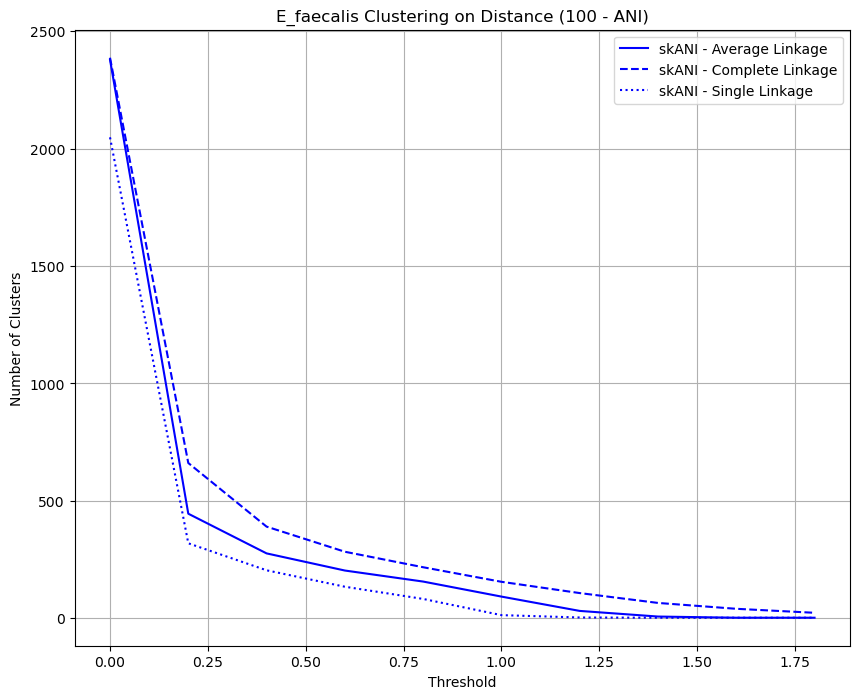

In [39]:
threshold_values = [i / 10 for i in range(0, 20, 2)]

skani_results_avg = {}
skani_results_compl = {}
skani_results_single = {}

for threshold in threshold_values:
    # average
    skani_res_a = get_clustered_matrix(dissimilarity_matrix, average, threshold, 'distance')
    skani_clusters_a = skani_res_a[1]
    num_skani_clusters_a = len(set(skani_clusters_a.values()))
    skani_results_avg[threshold] = num_skani_clusters_a

    # complete
    skani_res_c = get_clustered_matrix(dissimilarity_matrix, complete, threshold, 'distance')
    skani_clusters_c = skani_res_c[1]
    num_skani_clusters_c = len(set(skani_clusters_c.values()))
    skani_results_compl[threshold] = num_skani_clusters_c

    # single
    skani_res_s = get_clustered_matrix(dissimilarity_matrix, single, threshold, 'distance')
    skani_clusters_s = skani_res_s[1]
    num_skani_clusters_s = len(set(skani_clusters_s.values()))
    skani_results_single[threshold] = num_skani_clusters_s

plt.figure(figsize=(10, 8))

plt.plot(list(skani_results_avg.keys()), list(skani_results_avg.values()), 'b-', label='skANI - Average Linkage')
plt.plot(list(skani_results_compl.keys()), list(skani_results_compl.values()), 'b--', label='skANI - Complete Linkage')
plt.plot(list(skani_results_single.keys()), list(skani_results_single.values()), 'b:', label='skANI - Single Linkage')

plt.title(f'{species} Clustering on Distance (100 - ANI)')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [40]:
def get_y_for_x(x_value, results_dict):
    x_points = list(results_dict.keys())
    y_points = list(results_dict.values())
    
    y_interpolated = np.interp(x_value, x_points, y_points)
    return y_interpolated

x_value = 2

y_skani_avg = get_y_for_x(x_value, skani_results_avg)
y_skani_compl = get_y_for_x(x_value, skani_results_compl)
y_skani_single = get_y_for_x(x_value, skani_results_single)

print(f"Y values for x = {x_value}:")
print(f"skANI - Average Linkage: {y_skani_avg}")
print(f"skANI - Complete Linkage: {y_skani_compl}")
print(f"skANI - Single Linkage: {y_skani_single}")

Y values for x = 2:
skANI - Average Linkage: 2.0
skANI - Complete Linkage: 23.0
skANI - Single Linkage: 2.0


In [41]:
def get_clusters_for_linkage(distance_matrix, linkage_function, threshold, tool_name, linkage_name):
    res = get_clustered_matrix(distance_matrix, linkage_function, threshold, 'distance')

    clusters = res[1]

    clusters_samples_dict = defaultdict(list)
    for sample, cluster_id in clusters.items():
        clusters_samples_dict[cluster_id].append(sample)

    # print(f"\nClusters for {tool_name} with {linkage_name} linkage at threshold {threshold}:")
    for cluster_id, samples in clusters_samples_dict.items():
        # print(f"Cluster {cluster_id}:")
        # for sample in samples:
        #     print(f"  {sample}")
        samples_array = np.array(samples)
        # print(f"Cluster {cluster_id}: {samples_array}")
    return clusters_samples_dict

tools = [
    (dissimilarity_matrix, 'skANI', [average, 'Average Linkage'], [complete, 'Complete Linkage'], [single, 'Single Linkage'])
]

for distance_matrix, tool_name, *linkages in tools:
    for linkage_function, linkage_name in linkages:
        get_clusters_for_linkage(distance_matrix, linkage_function, x_value, tool_name, linkage_name)

COMPARING TOOLS

In [42]:
melted_df = pd.melt(skani_matrix, id_vars=['Tool'], value_vars=['ANI', 'aligned_bases1'], var_name='Type', value_name='Value')
melted_df

,Tool,Type,Value
0,skANI,ANI,100.000000
1,skANI,ANI,98.490000
2,skANI,ANI,98.950000
3,skANI,ANI,98.770000
4,skANI,ANI,98.590000
...,...,...,...
9039037,skANI,aligned_bases1,82.560500
9039038,skANI,aligned_bases1,86.304498
9039039,skANI,aligned_bases1,100.000000
9039040,skANI,aligned_bases1,86.134884


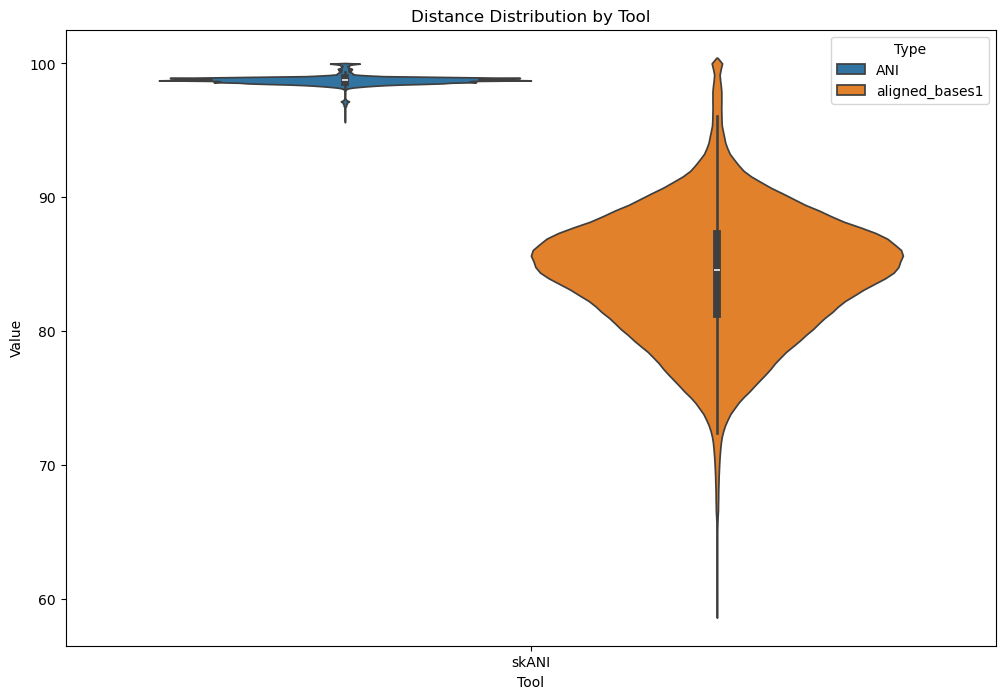

In [43]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=melted_df, x='Tool', y='Value', hue='Type')
plt.title('Distance Distribution by Tool')
plt.show()

In [44]:
filtered_melted_df = melted_df[melted_df['Type'] == 'ANI']
filtered_melted_df

,Tool,Type,Value
0,skANI,ANI,100.00
1,skANI,ANI,98.49
2,skANI,ANI,98.95
3,skANI,ANI,98.77
4,skANI,ANI,98.59
...,...,...,...
4519516,skANI,ANI,97.13
4519517,skANI,ANI,98.42
4519518,skANI,ANI,100.00
4519519,skANI,ANI,97.13


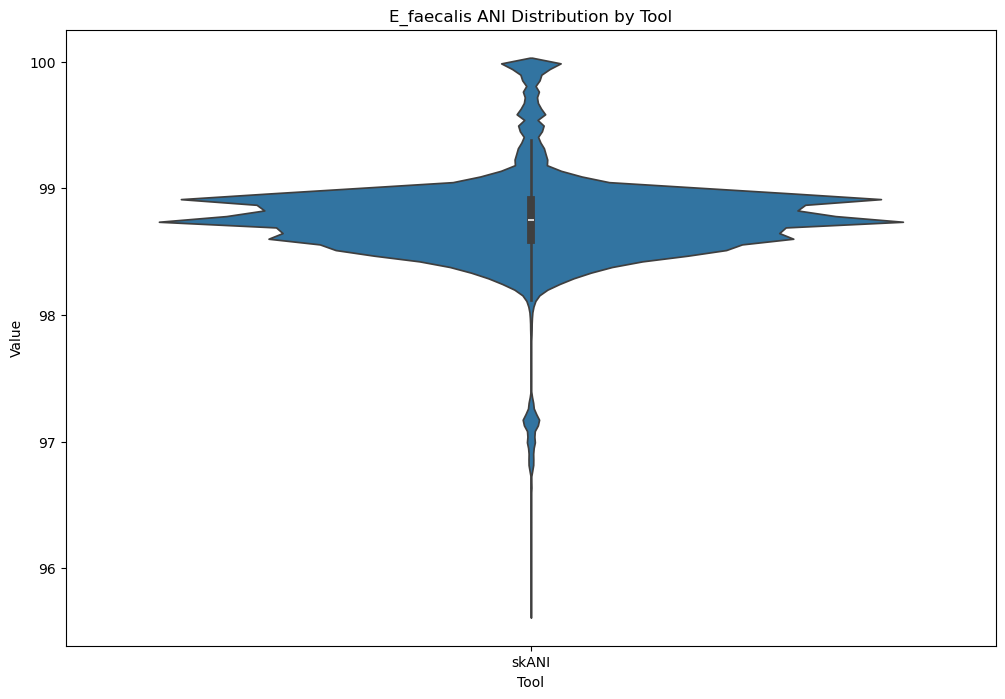

In [45]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=filtered_melted_df, x='Tool', y='Value')
plt.title(f'{species} ANI Distribution by Tool')
plt.show()

CLUSTER QUALITY CHECK

(to be updated)

In [46]:
ari_results = []

for i in range(len(tools)):
    for j in range(i + 1, len(tools)):
        tool_1 = columns[i]
        tool_2 = columns[j]
        
        ari = adjusted_rand_score(merged_df[tool_1], merged_df[tool_2])
        
        ari_results.append({'tool 1': tools[i], 'tool 2': tools[j], 'ARI': ari})

ari_df = pd.DataFrame(ari_results)
ari_df

""


In [47]:
def create_pairwise_matrix(cluster_labels):
    n = len(cluster_labels)
    pairwise_matrix = pd.DataFrame(0, index=range(n), columns=range(n))
    
    for i in range(n):
        for j in range(i, n):
            if cluster_labels[i] == cluster_labels[j]:  # Same cluster
                pairwise_matrix.at[i, j] = 1
                pairwise_matrix.at[j, i] = 1
    return pairwise_matrix

def calculate_jaccard_index(pairwise_matrix_1, pairwise_matrix_2):
    matrix_1_flat = pairwise_matrix_1.values.flatten()
    matrix_2_flat = pairwise_matrix_2.values.flatten()
    
    return jaccard_score(matrix_1_flat, matrix_2_flat)

tools = ['skder', 'cidder', 'drep', 'galah']
columns = ['nearest_representative_genome(s)_skder', 'nearest_representative_genome(s)_cidder', 
           'secondary_cluster', 'nearest_representative_genome(s)']

jaccard_results = []

pairwise_matrices = {}
for tool, column in zip(tools, columns):
    pairwise_matrices[tool] = create_pairwise_matrix(merged_df[column].values)

for tool_1, tool_2 in combinations(tools, 2):
    pairwise_matrix_1 = pairwise_matrices[tool_1]
    pairwise_matrix_2 = pairwise_matrices[tool_2]
    
    jaccard_index = calculate_jaccard_index(pairwise_matrix_1, pairwise_matrix_2)
    
    jaccard_results.append({'tool 1': tool_1, 'tool 2': tool_2, 'Jaccard Index': jaccard_index})

jaccard_df = pd.DataFrame(jaccard_results)
jaccard_df

NameError: name 'merged_df' is not defined